INTRODUCCION: 

En este proyecto, exploraremos datos de la plataforma Steam, líder mundial en la venta digital de licencias de videojuegos para PC. Utilizaremos técnicas de web scraping para recopilar información de su sitio web oficial y emplearemos expresiones regulares para validar y extraer datos relevantes. Para luego, combinar esta información con un archivo CSV detallado (de steam) utilizando la biblioteca pandas de Python. Con el  objetivo final de analizar y visualizar las relaciones entre los datos utilizando grafos con NetworkX.

Bibliotecas utilizadas:
- BeautifulSoup
- Requests
- Re
- Pandas
- Networkx
- matplotlib.pyplot

Inicio del web scrapping

In [47]:
url_base = "https://store.steampowered.com/" #Guardamos el url base que usaremos. para el web scrapping
from bs4 import BeautifulSoup #Importamos beatifulsoup para la lectura del contenido de nuestros links.

In [48]:
import requests #Importamos request para obtener información de la URL
respuesta_articulo=requests.get(url_base) #Guardamos el request del url deseado.
sopa_articulo = BeautifulSoup(respuesta_articulo.text) #Guardamos el contenido del request.
contenido =sopa_articulo.find_all("div", {"class":"tab_see_more"}) #Guardamos en contenido las ventanas que deseamos.
print(contenido[1]) #de la pagina principal, obtenemos la vista completa de los juegos más vendidos.

<div class="tab_see_more">
							See more:															<span class="topsellers_see_more" data-searchid="default" style="">
<a class="btnv6_white_transparent btn_small_tall" href="https://store.steampowered.com/search/?filter=topsellers&amp;os=win&amp;snr=1_4_4__tabsmore">
<span>Top Sellers</span>
</a>
</span>
<span class="topsellers_see_more" data-searchid="hidef2p" style="display: none;">
<a class="btnv6_white_transparent btn_small_tall" href="https://store.steampowered.com/search/?filter=topsellers&amp;os=win&amp;hidef2p=1&amp;snr=1_4_4__tabsmore">
<span>Top Sellers</span>
</a>
</span>
</div>


Expresiones regulares

In [49]:
import re #importamos la librearía para el uso de expresiones regulares.
top = re.findall('https[\S ]+re',str(contenido[1])) #Usamos las expresiones regulares para eliminar datos no deseados y obtener el link
print(top[0]) # obtenemos unicamente el link de los juegos más vendidos de steam. devuelve el primer enlace encontrado en el contenido HTML

https://store.steampowered.com/search/?filter=topsellers&amp;os=win&amp;snr=1_4_4__tabsmore


Obtengo nombre y precio desde la web

In [50]:
import re
from bs4 import BeautifulSoup
import requests

def nombres_y_precios(cantidad):
    respuesta_articulo = requests.get(top[0]) # obtenemos el request para ver la lista de todos los juegos más vendidos.
    sopa_articulo = BeautifulSoup(respuesta_articulo.text, 'html.parser') #Guardamos el contenido del request.
    contenido1 = sopa_articulo.find_all("div", {"class": "col search_name ellipsis"}) #Guardamos el contenido obtenido de la web
    contenido2 = sopa_articulo.find_all("div", {"class": "responsive_search_name_combined"}) #Guardamos el contenido obtenido de la web
    
    nombres = [] #Creamos una lista vacía.
    precios = [] #Creamos una lista vacía.
    
    for i in range(cantidad):
        nombre = contenido1[i].text.replace("\n", "")
        nombres.append(nombre)
        
        precio = obtener_precio(contenido2[i])
        precios.append(precio)
    
    return nombres, precios

def obtener_precio(contenido):
    x2 = re.findall('data-price-.+', str(contenido))
    precio = re.findall('[0-9]+', str(x2)) #expresiones regulares, limpio los datos, busco los numeros
    if precio:
        return precio[0]
    else:
        return 'Precio no disponible'

NOMBRES, PRECIOS = nombres_y_precios(50) # la cantidad mostrada varia de acuerdo al usuario. Se establece en 50


DataFrame de datos recopilados de web scrapping y expresiones regulares

In [51]:
import pandas as pd
# Creo un DataFrame con los nombres y precio
nombres_set = set(NOMBRES) # Convierto la lista 'NOMBRES' a un conjunto para no tenes problemas con los filtros
nombres_limpios = [nombre.strip() for nombre in nombres_set] # Esto Limpia los nombres eliminando los espacios en blanco al final, no me estaba devolviendo nada el df cuando lo relacionaba con el csv

df = pd.DataFrame({
    'Nombre': NOMBRES,
    'Precio': PRECIOS,
})
df.at[0, 'Precio'] = 0 # Modifico el valor directamente, yo se que es 0 nose porque toma un valor de 1999, el resto de la lista esta OK
df.at[12, 'Precio'] = 1498 # Modifico el valor directamente
df['Precio'] = df['Precio'].astype(float, errors = 'raise') # hacemos la tranformación a flotante.
precioN=df["Precio"]/100 # Dividimos entre 100 el precio para que tenga sentido.
df["Precio"]=precioN #Guardamos la división realizada.
df.head(20)


,Nombre,Precio
0,"Warhammer 40,000: Space Marine 2",0.00
1,Steam Deck,0.00
2,Counter-Strike 2,14.99
3,Once Human,0.00
4,Black Myth: Wukong,59.99
5,Forza Horizon 4,3.99
6,Ghost of Tsushima DIRECTOR'S CUT,39.99
7,NBA 2K25,69.99
8,Forza Horizon 5,16.39
9,The Last of Us™ Part I,35.99


Trabajo con mi data frame y una base de datos .CSV y asi generar uno nuevo

In [52]:
import pandas as pd

# Leo el archivo CSV bajado de internet "https://www.gigasheet.com/sample-data/top-1000-steam-games-2023" y cargarlo en un DataFrame para relacionarlo con los datos optenidos del web scrapping y expreciones reculares
df_steam = pd.read_csv('Dataset_steam.csv')

# Filtrar el DataFrame 'df_steam' utilizando la consulta
df_filtrado = df_steam[df_steam['name'].str.strip().isin(nombres_limpios)]

#recorto columnas que no voy a necesitar/usar
df_filtrado = df_filtrado.drop(columns=['userscore','average_forever','average_2weeks','median_forever','median_2weeks','initialprice','discount','tags','score_rank']) 

#renombro columnas
df_filtrado = df_filtrado.rename(columns={'appid': 'ID', 
                                          'name': 'Nombre',
                                          'developer': 'Desarrolladora',
                                          'publisher': 'Publicadora',
                                          'positive': 'V. Positiva',
                                          'negative': 'V. Negativa',
                                          'owners': 'Propietarios',
                                          'price': 'Precio',
                                          'languages': 'Lenguajes',
                                          'genre': 'Genero',
                                          'ccu': 'Media simultaneo',
                                          })

precioNum=df_filtrado["Precio"]/100 # Dividimos entre 100 el precio para que tenga sentido.
df_filtrado["Precio"]=precioNum #Guardamos la división realizada.

# Guardar el DataFrame filtrado en un nuevo archivo CSV
df_filtrado.to_csv('df_filtrado.csv', index=False)

# Mostramos
df_filtrado.head(10)


,ID,Nombre,Desarrolladora,Publicadora,V. Positiva,V. Negativa,Propietarios,Precio,Lenguajes,Genero,Media simultaneo
22,570,Dota 2,Valve,Valve,1659573,355797,"200,000,000 .. 500,000,000",0.00,"English, Bulgarian, Czech, Danish, Dutch, Finn...","Action, Free to Play, Strategy",524317
274,221100,DayZ,Bohemia Interactive,Bohemia Interactive,260025,92525,"5,000,000 .. 10,000,000",44.99,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, Massively Multiplayer",49312
298,230410,Warframe,Digital Extremes,Digital Extremes,469875,73740,"20,000,000 .. 50,000,000",0.00,"English, German, French, Italian, Korean, Span...","Action, Free to Play, RPG",44354
367,252490,Rust,Facepunch Studios,Facepunch Studios,824082,123399,"20,000,000 .. 50,000,000",39.99,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, Indie, Massively Multiplaye...",124008
401,271590,Grand Theft Auto V,Rockstar North,Rockstar Games,1360117,223755,"50,000,000 .. 100,000,000",15.20,"English, French, Italian, German, Spanish - Sp...","Action, Adventure",159766
489,323190,Frostpunk,11 bit studios,11 bit studios,85444,7475,"2,000,000 .. 5,000,000",5.99,"English, French, German, Spanish - Spain, Poli...","Simulation, Strategy",2870
555,381210,Dead by Daylight,Behaviour Interactive Inc.,Behaviour Interactive Inc.,541254,134983,"10,000,000 .. 20,000,000",7.99,"English, French, Italian, German, Spanish - Sp...",Action,39494
678,526870,Satisfactory,Coffee Stain Studios,Coffee Stain Publishing,131899,3939,"5,000,000 .. 10,000,000",29.99,"English, French, Italian, German, Spanish - Sp...","Adventure, Indie, Simulation, Strategy, Early ...",14795
706,578080,PUBG: BATTLEGROUNDS,"KRAFTON, Inc.","KRAFTON, Inc.",1260926,939005,"50,000,000 .. 100,000,000",0.00,"English, Korean, Simplified Chinese, French, G...","Action, Adventure, Free to Play, Massively Mul...",292875
712,582660,Black Desert,Pearl Abyss,Pearl Abyss,52347,17579,"5,000,000 .. 10,000,000",9.99,"English, French, German, Spanish - Spain, Japa...","Action, Adventure, Massively Multiplayer, RPG,...",29906


Visualizacion de grafos con NetworkX

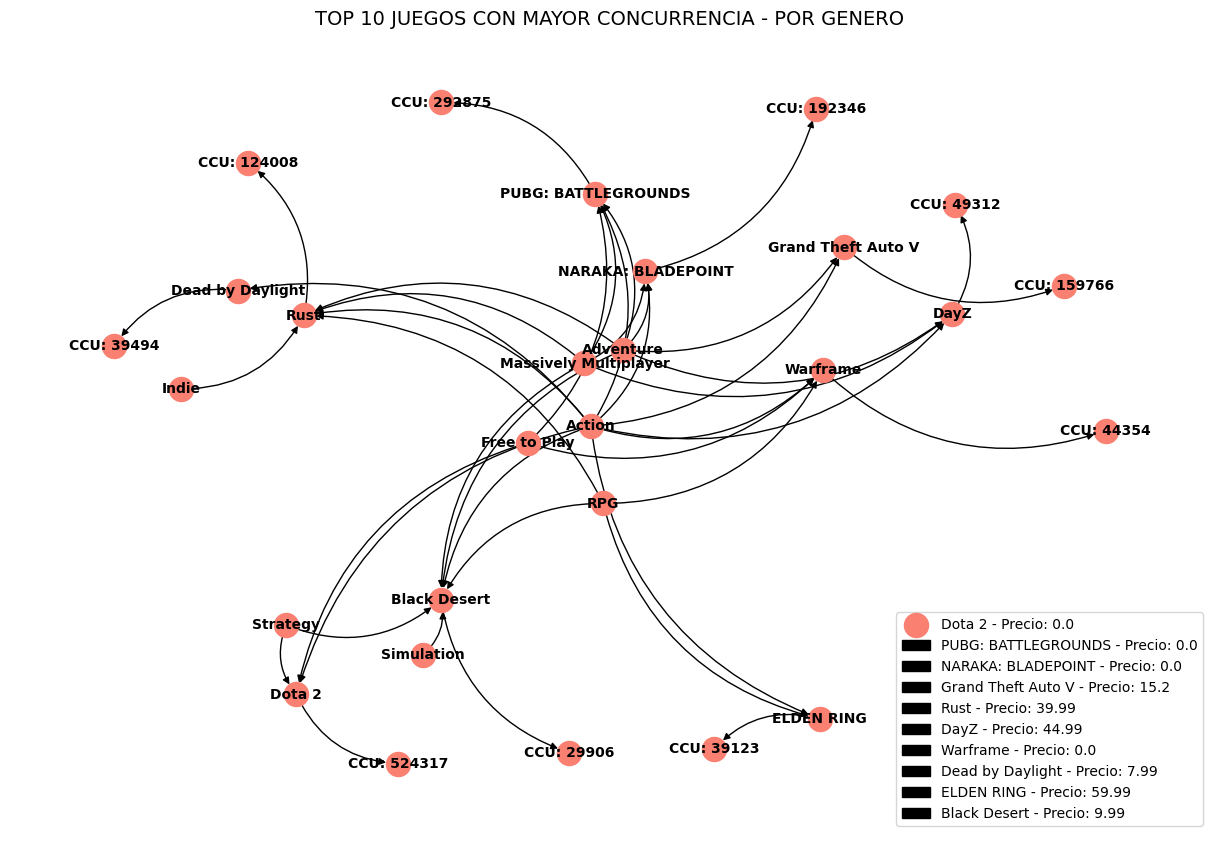

In [53]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Obtengo el top 10, segun la columna media simultaneo de mi df_filtrado
top_10_media_simultaneo = df_filtrado.nlargest(10, 'Media simultaneo')

# Creo  grafo dirigido
G = nx.DiGraph()

# Creo nodos para géneros, media simultáneo y nombre recorriendo mi df 
for _, row in top_10_media_simultaneo.iterrows():
    generos = row['Genero'].split(', ')
    media_simultaneo = row['Media simultaneo']
    nombre = row['Nombre']
    
    for genero in generos:
        G.add_node(genero)
        # Agrega conexión entre género y media simultáneo
        G.add_edge(genero, nombre)
        # Agrega conexión entre media simultáneo y nombre
        G.add_edge (nombre, media_simultaneo)

# Ciclo para cambiar recorrer y agregar a las etiquetas de genero el texto CCU: para no visualizar solamente un numero
etiqueta = {}
for node in G.nodes():
    if node in top_10_media_simultaneo['Media simultaneo'].values:
        etiqueta[node] = f"CCU: {node}"
    else:
        etiqueta[node] = node


# seteo las posiciones estaticas asi lo dejo mas a mi gusto
pos = nx.spring_layout(G, seed=1,k=0.5)

# Detalles de visualizacion de flechas con arcos, colores, etiquetas, tamaño.
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, labels=etiqueta, font_weight='bold', arrows=True, node_color="salmon", connectionstyle="arc3,rad=0.3",font_size='10')

# Título
plt.title("TOP 10 JUEGOS CON MAYOR CONCURRENCIA - POR GENERO", fontsize=14)

# cuadro tipo leyenda (solo para agregar mas informacion visual)
legend_labels = [f"{row['Nombre']} - Precio: {row['Precio']}" for _, row in top_10_media_simultaneo.iterrows()]
plt.legend(legend_labels, loc='lower right')

plt.show()

CONCLUSION:
En el grafo tenemos el top 10 de los juegos mas adquiridos en la plataforma que a su vez esta relacionado con la media de jugadores simultaneos que tiene cada uno de ellos como parametro al momento de evaluar. Podemos observar como resultado un grafo debilmente conexo en el cual vemos la relacion directa que hay con los generos de cada video juego y a su vez, estos con su media mas alta de jugadores o por sus siglas en ingles CCU (Currently Concurrent Users). Estando en primer lugar tenemos al video juego Dota 2 con solamente 3 generos (Action/Strategy/Free to play) y con un costo en el mercado de $$0.0 pero aun asi siendo el juego con mayor cantidad de usuarios conectados. Diferente a por ejemplo, Rust que esta en el puesto 5 y tiene un apartado de generos mas amplio.


NUEVO ANALISIS - PARTE 2


Continuando con la base de datos de STEAMPOWERED, la reconocida página de distribución de licencias digitales, vamos a realizar un modelo de Regresión Lineal Múltiple (RLM) para poder hacer una predicción sobre el posible puntaje que puede dar el reconocido sitio web METACRITIC. Este sitio recopila diversa información sobre los videojuegos (reseñas, recomendaciones, valoraciones, etc.) para puntuar cada título, en este caso, de la plataforma STEAM. Nosotros tomamos como referencia de nuestra base de datos las valoraciones positivas, negativas, recomendaciones, precio y el promedio de tiempo de juego destinado a cada título. (Estas se eligieron por que a la hora de valorar un juego se tiene muy en cuenta la opinion de los usuarios, tiempo dedicado y el costo del mismo)

Detalles columnas original DF:
- AppId: Codigo identificatorio del juego 
- Name: Nombre del titulo.
- Release Date: Fecha de lanzamiento en la plataforma:
- Estimated Owners: Gente que estimada que adquirio el juego.
- Peak CCU: Pico de jugadores en simultaneo.
- Price: Valor del juego en dolares.
- DLC Count: Contador de contenido extra.
- About the game: Un breve resumen de cada titulo.
- Supported lenguages: Idiomas disponibles.
- Full Audio Languages: Idiomas disponibles (audio).
- Reviews: Reseña del juego.
- Header Image: Link a la imagen de portada.
- Website: Pagina web oficial.
- Support URL: Pagina web de oficial para soporte.
- Windows/Mac/Linux: Indica si esta disponible o no en cada OS.
- Metacritic Score: Nota que se le dio al titulo.
- Metracritic URL: Pagina web a los juegos que ya poseen su valoracion.
- User Score: Puntaje del usuario.
- Positive: Valoraciones positiva dentro de STEAM.
- Negative: Valoraciones negativas dentro de STEAM.
- Archivements: Logros disponibles y su cantidad.
- Recommendations: Recomendaciones dentro de STEAM.
- Average Playtime Forever: Promedio de juego promedio.
- Average playtime two weeks: Promedio de juego en las ultimas dos semanas.
- Media playtime forever: Media de juego (tiempo)
- Media playtime two weeks: Media de juego en las ultimas dos semanas (tiempo)
- Developers: Nombres de las desarrolladoras que participaron.
- Publishers: Nombres de las publicadores que participaron.
- Categories: Categorias de los juegos, dentro de la plataforma.
- Genres: Generos de los juegos, accion, aventura, etc.
- Tag: Indicadores del juego para filtros.
- Screenshots: URL de deposito de capturas de pantalla del titulo.
- Movies: Trailers / videos.

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

#dfOriginal= pd.read_csv('datasetsteam.csv', low_memory=False) #trabajo con la base de datos recopilados de steam
#pd.options.display.max_columns = None # muestro todas las columnas asi me es mas facil visualizarlo (esto lo use al comienzo para visualizar bien los datos, idem abajo)
#pd.options.display.max_rows = None# muestro todas las columnas asi me es mas facil visualizarlo
#dfOriginal = dfOriginal.drop(dfOriginal[dfOriginal['Metacritic score'] == 0].index) # En la base de datos tengo juegos que no estan incluidos.
#ColumnasNuevoDf = ['Metacritic score','Positive','Negative','Recommendations','Price','Average playtime forever'] #creo un nuevo con las columnas que voy a usar, eran muchas mas pero recorte a las necesarias
#df = dfOriginal[ColumnasNuevoDf]
#df.to_csv('datasetsteam2.csv', index=False)

# Debido al tamaño de 200mb del csv creditos a https://www.kaggle.com/datasets/fronkongames/steam-games-dataset/code decidi reducir la informacion y crear un nuevo csv para poder subir el proyecto

df= pd.read_csv('datasetsteam2.csv')
df.head(20)

,Metacritic score,Positive,Negative,Recommendations,Price,Average playtime forever
0,62,589,212,427,23.99,67
1,64,349,134,285,9.99,44
2,53,1716,628,1140,19.99,324
3,84,698,203,815,3.99,83
4,89,9516,1114,8684,3.49,168
5,70,207,98,102,14.99,360
6,86,82902,3014,80467,24.99,3574
7,40,245,130,226,9.99,139
8,87,2108,111,1996,16.24,171
9,92,16788,1211,13997,9.99,1034


In [55]:
df.describe() #Detalles estadísticos del conjunto de datos

,Metacritic score,Positive,Negative,Recommendations,Price,Average playtime forever
count,3912.000000,3.912000e+03,3912.000000,3.912000e+03,3912.000000,3912.000000
mean,72.841513,1.265745e+04,1700.738753,9.756470e+03,14.898305,643.440440
std,10.565931,1.067054e+05,14736.899957,6.834469e+04,11.701276,1800.954929
min,20.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,67.000000,2.227500e+02,62.000000,1.900000e+02,6.990000,42.000000
50%,74.000000,9.335000e+02,199.000000,8.065000e+02,12.990000,217.500000
75%,80.000000,4.484750e+03,743.250000,3.758500e+03,19.990000,563.000000
max,97.000000,5.764420e+06,766677.000000,3.441592e+06,69.990000,42773.000000


In [56]:
df.isnull().any() #veo si tengo datos faltantes.

Metacritic score            False
Positive                    False
Negative                    False
Recommendations             False
Price                       False
Average playtime forever    False
dtype: bool

* TABLA DE CORRELACIONES

<Axes: >

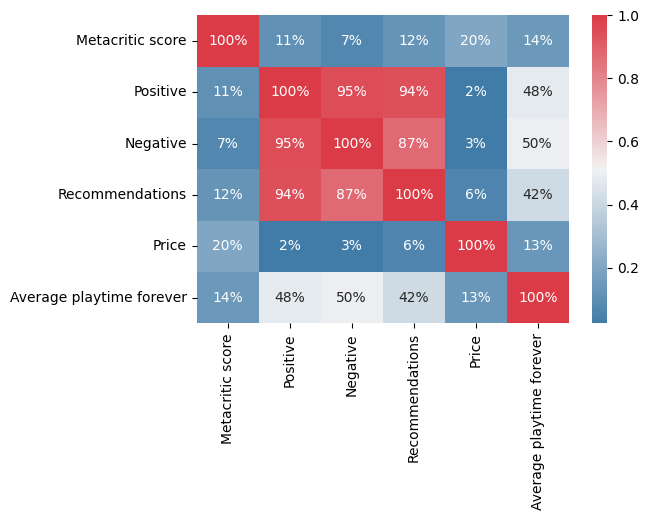

In [57]:
#sns.pairplot(df)
corr = df.corr()
plt.subplots(figsize=(6,4))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, fmt='.0%',
cmap=sns.diverging_palette(240, 10, as_cmap=True)) 

* MODELO REGRESION LINEAL MULTIPLE (1)

In [58]:
X = df[['Positive', 'Negative', 'Recommendations','Price','Average playtime forever']].values
y = df['Metacritic score'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

#Revisemos la diferencia entre el valor real y el valor previsto.

df_prediccion = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df_prediccion.head(25)
df1.head()

,Actual,Predicted
0,76,75.929759
1,68,71.623193
2,55,71.614489
3,74,73.255238
4,73,72.803722


PREDICCION CON NUEVA INFORMACION

In [59]:
# Predicción con nuevos datos
nuevo = np.array([[200, 100, 80, 0, 200]]) # 	Positive	/ Negative / 	Recommendations	Price /	Average playtime forever
print(f"Nueva prediccion: {regressor.predict(nuevo).round(2)}")

Nueva prediccion: [69.81]


In [60]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred)) 
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred)) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 7.482760867266387
Mean Squared Error: 91.41048882900897
Root Mean Squared Error: 9.560883266153237


* Mean Absolute Error (MAE): El valor de MAE = 7.482760867266387. Esto significa que en promedio, las predicciones del modelo tienen un error absoluto de alrededor de 7.48 unidades en la misma escala que la variable objetivo.

* Mean Squared Error (MSE): El valor de MSE = 91.41048882900897. Esto indica que en promedio, el cuadrado del error entre las predicciones del modelo y los valores reales es de aproximadamente 91.41 unidades.

* Root Mean Squared Error (RMSE): El valor de RMSE = 9.560883266153237. Esto es la raíz cuadrada del MSE y sugiere que en promedio, el error entre las predicciones del modelo y los valores reales es de alrededor de 9.56 unidades en la misma escala que la variable objetivo.

* VALIDACION DEL SISTEMA

Creo devuelta el modelo eliminado la columna Average para verificar si mi predicciones se mantiene en valores normales.

In [66]:
ColumnasValidacionDf = ['Metacritic score','Positive','Negative','Recommendations','Price'] #Elimino Average playtme forever para crear devuelta el modelo
dfValidacion = df[ColumnasValidacionDf]
dfValidacion.head()

,Metacritic score,Positive,Negative,Recommendations,Price
0,62,589,212,427,23.99
1,64,349,134,285,9.99
2,53,1716,628,1140,19.99
3,84,698,203,815,3.99
4,89,9516,1114,8684,3.49


In [62]:
dfValidacion.isnull().any() #veo si tengo datos faltantes.

Metacritic score    False
Positive            False
Negative            False
Recommendations     False
Price               False
dtype: bool

* MODELO REGRESION LINEAL MULTIPLE (2)

In [63]:
X2 = df[['Positive', 'Negative', 'Recommendations','Price']].values # omito columna eliminada
y = df['Metacritic score'].values
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

#Revisemos la diferencia entre el valor real y el valor previsto.

df_prediccion2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df2 = df_prediccion2.head(25)
df2.head()

,Actual,Predicted
0,76,75.203536
1,68,71.748590
2,55,71.743442
3,74,73.646571
4,73,72.745206


* PREDICCION CON NUEVA INFORMACION (2)

In [64]:
# Predicción con nuevos datos
nuevo2 = np.array([[200, 100, 80, 0]]) # 	Positive	/ Negative / 	Recommendations/	Price 
print(f"Nueva prediccion: {regressor.predict(nuevo2).round(2)}")

Nueva prediccion: [69.85]


* COMPARACION ENTRE VALOR REAL Y PREDICCION (GRAFICO AMBOS MODELOS)

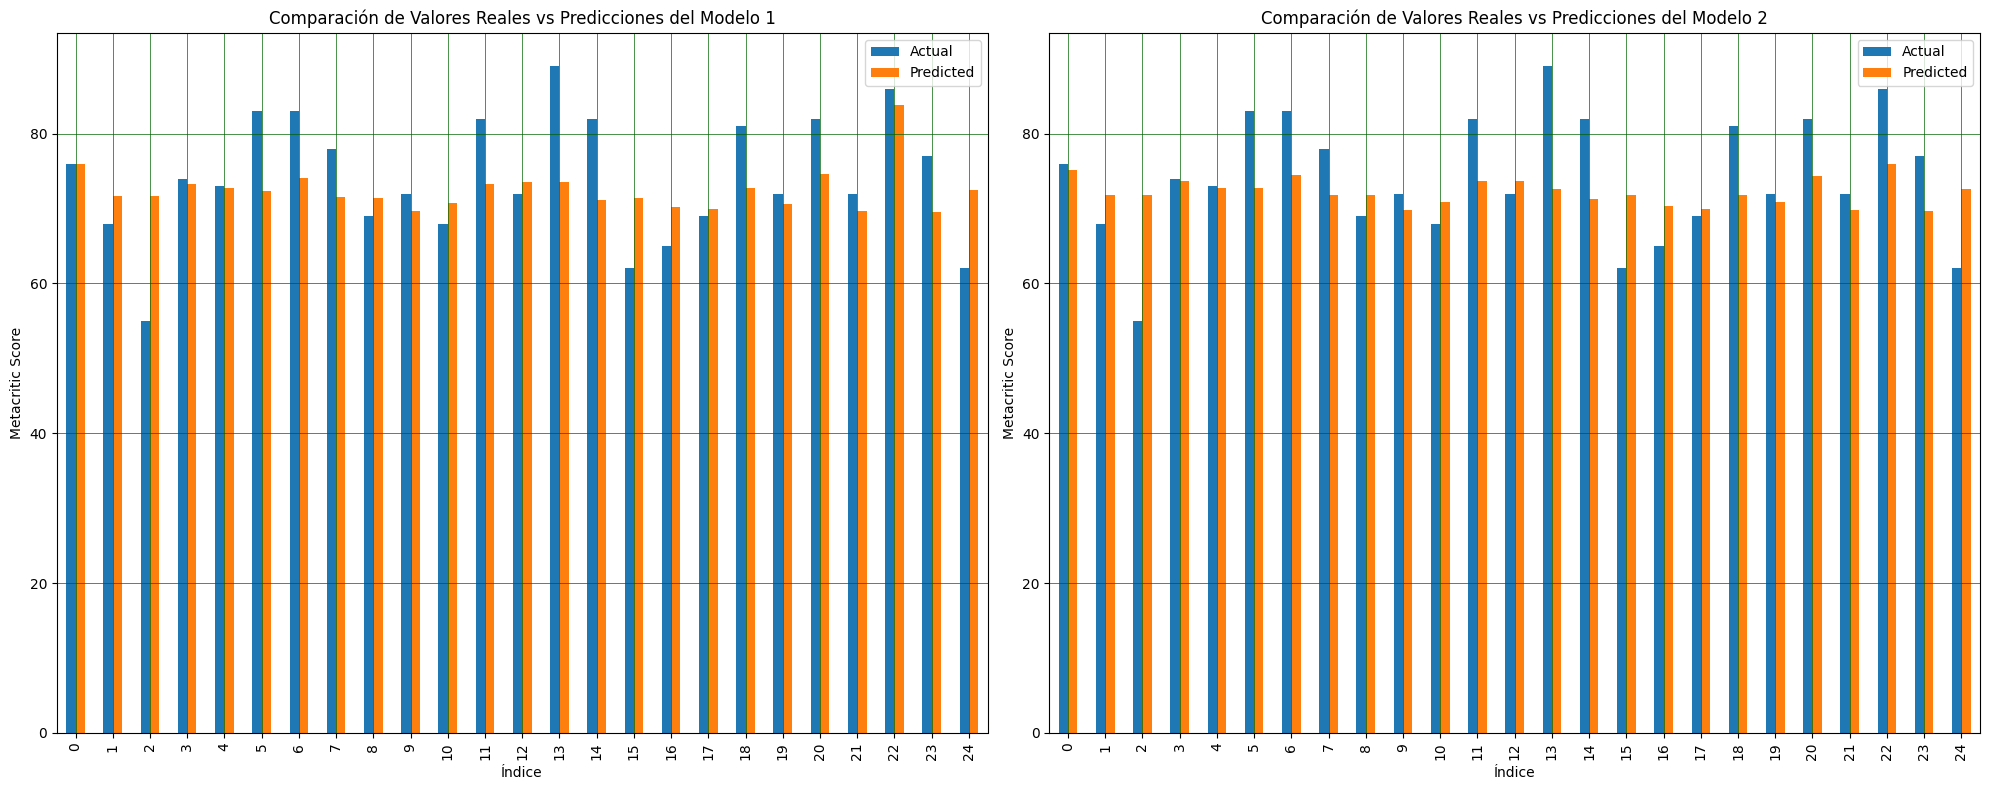

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Primer gráfico - df1
df1.plot(kind='bar', ax=axs[0], grid=True)
axs[0].set_title('Comparación de Valores Reales vs Predicciones del Modelo 1')
axs[0].set_xlabel('Índice')
axs[0].set_ylabel('Metacritic Score')
axs[0].grid(which='major', linestyle='-', linewidth='0.5', color='darkgreen')
axs[0].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

# Segundo gráfico - df2
df2.plot(kind='bar', ax=axs[1], grid=True)
axs[1].set_title('Comparación de Valores Reales vs Predicciones del Modelo 2')
axs[1].set_xlabel('Índice')
axs[1].set_ylabel('Metacritic Score')
axs[1].grid(which='major', linestyle='-', linewidth='0.5', color='darkgreen')
axs[1].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

* CONCLUSIÓN: Después de analizar ambos modelos, podemos verificar que nuestras predicciones se encuentran en valores normales y aceptables para funcionar correctamente. En la comparativa de los gráficos, podemos ver que el modelo 1 tiene una mínima mejora con respecto a la comparación de los valores reales y las predicciones.